<p style="font-size:14pt;text-align:center;">
Pretraining network on pascal VOC.
</p>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
from theano import tensor as T
import pickle as pk
import re
from copy import deepcopy
import sys

# image processing
from skimage.io import imread
from skimage.transform import resize

import lasagne
from lasagne.layers import Pool2DLayer, Conv2DLayer, dropout, \
    DenseLayer, InputLayer, get_output, get_all_params

import pdb

Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
jupyter_stdout = sys.stdout

In [3]:
with open('/usr/local/python/bnr_ml/data/PascalVOC/annotations.txt', 'rb') as f:
    annotations = pk.load(f)['annotations']

In [4]:
def add_proper_labels(annotations):
    for im in annotations:
        for obj in im:
            if 'car' in obj['label'].lower():
                obj['label'] = 'car'
            elif 'bicycle' in obj['label'].lower():
                obj['label'] = 'bicycle'
            elif 'person' in obj['label'].lower():
                obj['label'] = 'person'
            elif 'bike' in obj['label'].lower():
                obj['label'] = 'bike'
            else:
                print obj

In [5]:
def get_label_counts(annotations):
    counts = np.zeros((4,))
    for im in annotations:
        for obj in im:
            if obj['label'] == 'car':
                counts[0] += 1
            elif obj['label'] == 'bicycle':
                counts[1] += 1
            elif obj['label'] == 'bike':
                counts[2] += 1
            else:
                counts[3] += 1
    return counts

In [6]:
add_proper_labels(annotations)

In [7]:
annotations = np.asarray(annotations)

In [8]:
counts = get_label_counts(annotations)

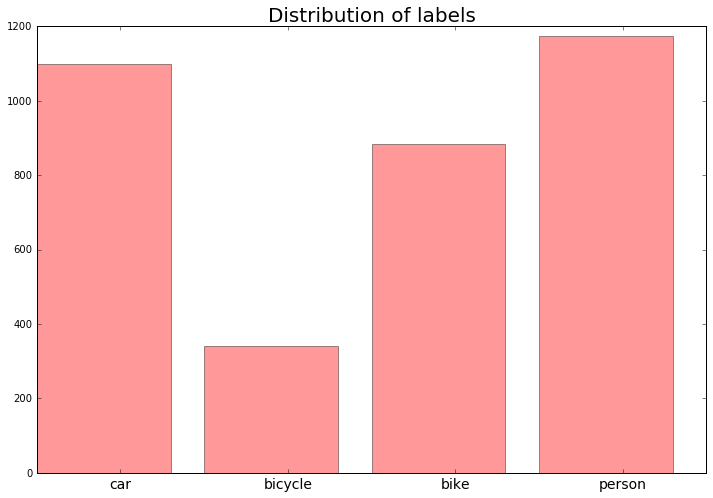

In [9]:
plt.figure(figsize=(12,8))
plt.title('Distribution of labels', fontsize=20)
plt.bar(np.arange(counts.size), counts, color='red', alpha=.4)
plt.xticks(np.arange(counts.size) + .5, ['car', 'bicycle', 'bike', 'person'], fontsize=14)
plt.show()

In [10]:
np.random.seed(1991)

<b>Split the annotations for training and testing, the reason I split by image and not individual object is so that when testing the performance, the network will never have seen any part of the test image.

In [11]:
Ntrain = np.int_(annotations.size * .8)
idx = np.arange(annotations.size)
np.random.shuffle(idx)
train_idx = idx[:Ntrain]
test_idx = idx[Ntrain:]

indices = {}
indices['train_index'] = train_idx
indices['test_index'] = test_idx

In [12]:
with open('indices.pkl', 'wb') as f:
    pk.dump(indices, f)

In [13]:
train_annotations = annotations[train_idx]
test_annotations = annotations[test_idx]

In [14]:
class Box(object):
    def __init__(self, xi,yi,xf,yf):
        self.xi = xi
        self.yi = yi
        self.xf = xf
        self.yf = yf
    def iou(self, box):
        isec = self.intersection(box)
        union = self.size() + box.size() - isec.size()
        return isec.size() / union
    def intersection(self, box):
        new_xi = max(self.xi, box.xi)
        new_yi = max(self.yi, box.yi)
        new_xf = min(self.xf, box.xf)
        new_yf = min(self.yf, box.yf)
        if new_xi > new_xf or new_yi > new_yf:
            new_xi, new_yi, new_xf, new_yf = 0., 0., 0., 0.
        return Box(new_xi, new_yi, new_xf, new_yf)
    def size(self):
        return (self.xf - self.xi) * (self.yf - self.yi)
    def width(self):
        return (self.xf - self.xi)
    def height(self):
        return (self.yf - self.yi)
    def copy(self):
        return Box(self.xi, self.yi, self.xf, self.yf)
    def subimage(self, im):
        xi = max(0, self.xi)
        yi = max(0, self.yi)
        xf = min(im.shape[1], self.xf)
        yf = min(im.shape[0], self.yf)
        return im[yi:yf, xi:xf]
    def round(self):
        self.xi, self.yi, self.xf, self.yf = round(self.xi), round(self.yi), round(self.xf), round(self.yf)
    def __str__(self):
        return '(' + str(self.xi) + ',' + str(self.yi) + ') (' + str(self.xf) + ',' + str(self.yf) + ')'
    def __repr__(self):
        return self.__str__()
    @staticmethod
    def gen_randombox(iou, box, eps=.5):
        angle = 2 * np.pi * np.random.rand()
        delx, dely = eps*np.cos(angle), eps*np.sin(angle)
        new_box = box.copy()
        while new_box.iou(box) > iou:
            new_box.xi += delx
            new_box.yi += dely
            new_box.xf += delx
            new_box.yf += dely
        return new_box

In [15]:
def generate_data(annotations, size=(200,200), augment=4, batch_size=100):
    '''
    augment: how many times do you want the data to be replicated
    '''
    def get_objects(annotations):
        objs = []
        for im in annotations:
            objs.extend([deepcopy(obj) for obj in im])
        return np.asarray(objs)
    def get_num_from_label(label):
        if label == 'car':
            return 0
        elif label == 'bicycle':
            return 1
        elif label == 'bike':
            return 2
        elif label == 'person':
            return 3
        elif label == 'noobj':
            return 4
        else:
            pass
#             print('This shouldn\'t happen')
    def subsample_objs(objs, obj_idx, size):
        idx = obj_idx[np.random.random_integers(0,obj_idx.size-1, size=(size,))]
        copy_obj = []
        for obj in objs[idx]:
            copy_obj.append(deepcopy(obj))
        return np.asarray(copy_obj)
    def set_label_to_noobj(objs, obj_idx):
        N = np.int_(np.float_(obj_idx.size) / 5)
        idx = np.arange(obj_idx.size)
        np.random.shuffle(idx)
        for obj in objs[obj_idx[idx[:N]]]:
            obj['label']  = 'noobj'
        return objs
    
    # return flat list of objects
    objs = get_objects(annotations)
    
    # get number from label
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    max_labels = np.max([idx_car.size, idx_bicycle.size, idx_bike.size, idx_person.size])
    
    # get subsamples to get equal number of classes
    new_car = subsample_objs(objs, idx_car, max_labels - idx_car.size)
    new_bicycle = subsample_objs(objs, idx_bicycle, max_labels - idx_bicycle.size)
    new_bike = subsample_objs(objs, idx_bike, max_labels - idx_bike.size)
    new_person = subsample_objs(objs, idx_person, max_labels - idx_person.size)
    
    # add new samples
    objs = np.concatenate((objs, new_car, new_bicycle, new_bike, new_person))
    
    # get labels again
    labels = np.asarray([get_num_from_label(obj['label']) for obj in objs])
    
    idx = np.arange(labels.size)
    idx_car = idx[labels==0]
    idx_bicycle = idx[labels==1]
    idx_bike = idx[labels==2]
    idx_person = idx[labels==3]
        
    # set some of the objects to be used as an example of having no object
    objs = set_label_to_noobj(objs, idx_car)
    objs = set_label_to_noobj(objs, idx_bicycle)
    objs = set_label_to_noobj(objs, idx_bike)
    objs = set_label_to_noobj(objs, idx_person)
    
    np.random.shuffle(objs)
    
    cnt = 0
    while cnt < augment * objs.size:
        Xbatch = np.zeros((batch_size, 3) + size)
        ybatch = np.zeros((batch_size,5))
        batch_cnt = 0
        for j in range(batch_size):
            if cnt < augment * objs.size:
                obj = objs[cnt % objs.size]
                im = imread(obj['image'])
                im = im.astype(theano.config.floatX) / 255
                box = Box(*(obj['p1'] + obj['p2']))
                if obj['label'] == 'noobj':
                    iou = .08 * np.random.rand()
                else:
                    iou = .6 + 0.4 * np.random.rand()
                box = Box.gen_randombox(iou, box)
                im = box.subimage(im)
                if im.shape.__len__() == 2:
                    im = im.reshape(im.shape + (1,))
                    im = np.concatenate((im, im, im), axis=2)
                elif im.shape[2] == 4:
                    im = im[:,:,:3]
                if not (im.shape[0] == 0 or im.shape[1] == 0):
                    im = resize(im, size).swapaxes(2,1).swapaxes(1,0)
                    Xbatch[batch_cnt] = im
                    ybatch[batch_cnt, get_num_from_label(obj['label'])] += 1
                    batch_cnt += 1
            cnt += 1
        if batch_cnt < batch_size - 1:
            Xbatch, ybatch = Xbatch[:batch_cnt], ybatch[:batch_cnt]
        yield Xbatch.astype(theano.config.floatX), ybatch.astype(theano.config.floatX)

<b>Now we define the net for recognition.</b>

In [16]:
net = {}
net['input'] = InputLayer((None,3,200,200))
net['conv1'] = Conv2DLayer(net['input'], 16, (3,3))
net['conv2'] = Conv2DLayer(net['conv1'], 16, (3,3))
net['pool1'] = Pool2DLayer(net['conv2'], (2,2))
net['conv3'] = Conv2DLayer(net['pool1'], 32, (3,3))
net['conv4'] = Conv2DLayer(net['conv3'], 32, (3,3))
net['pool2'] = Pool2DLayer(net['conv4'], (2,2))
net['conv5'] = Conv2DLayer(net['pool2'], 64, (3,3))
net['conv6'] = Conv2DLayer(net['conv5'], 64, (3,3))
net['pool3'] = Pool2DLayer(net['conv6'], (2,2))
net['conv7'] = Conv2DLayer(net['pool3'], 64, (3,3))
net['conv8'] = Conv2DLayer(net['conv7'], 64, (3,3))
net['pool4'] = Pool2DLayer(net['conv8'], (2,2))
net['dense1'] = DenseLayer(dropout(net['pool4'], p=.8), 1000)
net['dense2'] = DenseLayer(dropout(net['dense1'], p=.8), 1000)
net['output'] = DenseLayer(dropout(net['dense2'], p=.5), 5, nonlinearity=lasagne.nonlinearities.softmax)

<b>Train the network

In [17]:
num_epochs = 100
batch_size = 100
test_every = 4

In [18]:
target = T.matrix('target')

In [19]:
output_train = get_output(net['output'], deterministic=False)
output_test = get_output(net['output'], deterministic=True)

params = get_all_params(net['output'])

cost_train = lasagne.objectives.categorical_crossentropy(output_train, target).mean()
cost_test = lasagne.objectives.categorical_crossentropy(output_test, target).mean()

updates = lasagne.updates.rmsprop(cost_train, params, learning_rate=1e-4)

train_fn = theano.function([net['input'].input_var, target], cost_train, updates=updates)
test_fn = theano.function([net['input'].input_var, target], cost_test, updates=updates)

/Library/Python/2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [21]:
stdout_filename = '/dev/stdout'

In [ ]:
train_loss = np.zeros((num_epochs,))
test_loss = np.zeros((num_epochs,))

for epoch in range(num_epochs):
    batch_loss = []
    
    for Xbatch, ybatch in generate_data(train_annotations):
        batch_loss.append(train_fn(Xbatch, ybatch))
    
    train_loss[epoch] = np.mean(batch_loss)
    print('Training loss: %.4f' % (train_loss[epoch],))
    with open(stdout_filename, 'w') as f:
        f.write('Training loss: %.4f' % (train_loss[epoch],))
    
    if epoch % test_every == 0:
        batch_loss = []
        for Xbatch, ybatch in generate_data(test_annotations, augment=1, batch_size=100):
            batch_loss.append(test_fn(Xbatch, ybatch))
        test_loss[epoch] = np.mean(batch_loss)
        print('Test loss: %.4f' % (test_loss[epoch],))
        with open(stdout_filename, 'w') as f:
            f.write('Training loss: %.4f ' % (test_loss[epoch],))

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Training loss: 0.5039
Test loss: 0.5812
Training loss: 0.4636
Training loss: 0.4725
Test loss: 0.6325
Training loss: 0.4539
Training loss: 0.4500
Training loss: 0.4473
Training loss: 0.4449
Test loss: 0.5574
Training loss: 0.4537
Training loss: 0.4408
Training loss: 0.4383
Training loss: 0.4408
Test loss: 0.5609
Training loss: 0.4255
Training loss: 0.4065
Training loss: 0.4186
Training loss: 0.4184
Test loss: 0.4988
Training loss: 0.4108


KeyboardInterrupt: 

In [155]:
# train_loss_total, test_loss_total = train_loss, test_loss
train_loss_total = np.concatenate((train_loss_total, train_loss))
test_loss_total = np.concatenate((test_loss_total, test_loss))

/Users/colingaudreau/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 400 but corresponding boolean dimension is 100


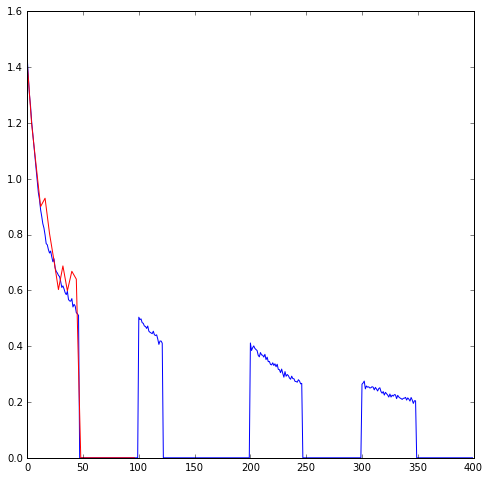

In [156]:
plt.figure(figsize=(8,8))
plt.plot(train_loss_total, 'b')
epochs = np.arange(num_epochs)
idx = epochs % test_every == 0
plt.plot(epochs[idx], test_loss_total[idx], 'r')

In [157]:
pred_fn = theano.function([net['input'].input_var], get_output(net['output']))

In [158]:
act_fn = theano.function([net['input'].input_var], get_output(net['pool4']))

In [159]:
def get_label(pred):
    idx = pred.argmax(axis=1)[0]
    if idx == 0:
        return 'car'
    elif idx == 1:
        return 'bicycle'
    elif idx == 2:
        return 'motorbike'
    elif idx == 3:
        return 'person'
    else:
        return 'nothing'

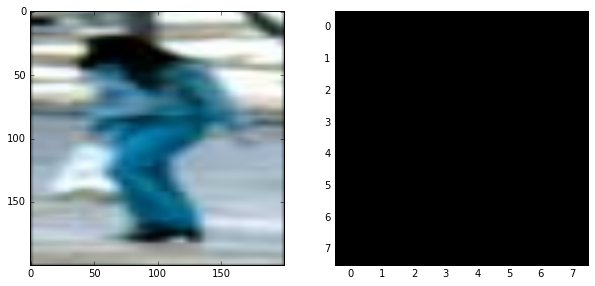

Label: person, Confidence: 0.9886


In [187]:
plt.figure(figsize=(10,10))
N = int(test_annotations.size * np.random.rand())
obj = test_annotations[N][0]
box = Box(*(obj['p1'] + obj['p2']))
im = imread(obj['image'])
im = box.subimage(im)
if im.shape.__len__() == 0:
    im = im.reshape(im.shape + (1,))
    im = np.concatenate((im,im,im),axis=2)
im = resize(im, (200,200)).swapaxes(2,1).swapaxes(1,0).reshape((1,3,200,200))
im = im.astype(theano.config.floatX)

pred = pred_fn(im)
act = act_fn(im)

plt.subplot(1,2,1)
plt.imshow(im[0].swapaxes(0,1).swapaxes(1,2))
plt.subplot(1,2,2)
plt.imshow(act[0,0], 'gray')
plt.show()

maxpred = pred.max(axis=1)[0]
print('Label: %s, Confidence: %.4f' % (get_label(pred), maxpred))

In [176]:
params = lasagne.layers.get_all_param_values(net['output'])

In [177]:
with open('pretrained_weights.pkl', 'wb') as f:
    pk.dump(params, f)